In [1]:
import sys
sys.path.append("../src/")


from kaggle_llm.core import (
    ROOT_PATH,
    count_words,
)
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import *
from sentence_transformers import SentenceTransformer
from pathlib import Path
import blingfire as bf
import argparse
import torch
import faiss
import json
import yaml


too_long_prompt_wc = 250
context_cutoff_len = 150


def split_text_into_chunks(text: str, chunk_size: int) -> List[str]:
    tokens = [i for i in text.split() if len(i) > 0]
    start = 0
    end = chunk_size
    chunks = []
    while end < len(tokens):
        chunks.append(" ".join(tokens[start: end]))
        start += chunk_size
        end += chunk_size
    return chunks


@torch.no_grad()
def get_sentence_embeddings(
        wiki_df_path: Union[str, Path],
        model: SentenceTransformer
):
    wiki_df = pd.read_csv(wiki_df_path, index_col=0)

    wc_per_page = wiki_df.groupby("page")[["word_count"]].sum().sort_values("word_count", ascending=False)
    black_list = list(wc_per_page.loc[
        (wc_per_page["word_count"] > 10000)
        | (wc_per_page.index.map(lambda x: "list of equations" in x.lower()))
    ].index)
    print(json.dumps(black_list, indent=4))

    filtered_wiki_df = wiki_df.loc[~wiki_df["page"].isin(black_list), :].copy()
    print(len(wiki_df), len(filtered_wiki_df))

    batch_size = 16
    sentences_df = []

    print("extracting sentences:")
    for _, row in tqdm(filtered_wiki_df.iterrows(), total=len(filtered_wiki_df)):
        _, sentence_offsets = bf.text_to_sentences_and_offsets(row["text"])
        for start_idx, end_idx in sentence_offsets:
            is_long_enough = (end_idx - start_idx) > 3
            is_math = "\\" in row["text"][start_idx: end_idx]  # leads to excessive tokens
            if is_long_enough and (not is_math):
                sentences_df.append({
                    "page": row["page"],
                    "i_sentence": len(sentences_df),
                    "text": row["text"][start_idx: end_idx],
                    "topic": row["page"],
                })

    sentences_df = pd.DataFrame.from_records(sentences_df)
    print(f"extracted: {len(sentences_df)} sentences")

    print(f"dropping too long sentences")
    pass_indices = sentences_df.loc[sentences_df["text"].apply(count_words) < context_cutoff_len, "text"].index
    print(f"keeping {len(pass_indices) / len(sentences_df) * 100} % at cutoff {context_cutoff_len}")
    sentences_df = sentences_df.loc[pass_indices, :].reset_index().copy()

    print("computing wiki embeddings:")
    sentence_embeddings = model.encode(
        sentences_df["text"].values,
        batch_size=batch_size,
        device="cuda",
        show_progress_bar=True,
        convert_to_tensor=True,
        normalize_embeddings=True,
    ).half()
    sentence_embeddings = sentence_embeddings.detach().cpu().numpy()

    sentence_index = faiss.IndexFlatIP(sentence_embeddings.shape[1])
    sentence_index.add(sentence_embeddings)
    print(f"{sentence_index.ntotal = }")
    return sentences_df, sentence_index

In [2]:
train_df_path = "/home/clay/research/kaggle/kaggle_llm/data/data_dumps/context_df/more_questions_raw_questions.csv"
wiki_df_path = "/home/clay/research/kaggle/kaggle_llm/data/physics_pages_list/physics_pages_formatted.csv"
sentence_model = "/home/clay/research/kaggle/kaggle_llm/data/sentence_transformer_model"
# sentence_model = "/home/clay/research/kaggle/kaggle_llm/data/data_dumps/sentence_embedder_modules/"
# sentence_model = "sentence-transformers/all-MiniLM-L6-v2"
k = 3

In [3]:
model = SentenceTransformer(sentence_model, device="cuda")
model.max_seq_length = 384
model = model.half()

In [4]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [5]:
wiki_df_path = Path(wiki_df_path)
print(f"computing wiki embeddings")
sentences_df, sentence_index = get_sentence_embeddings(wiki_df_path, model)
batch_size = 16
print(f"computed wiki embeddings")

computing wiki embeddings
[
    "Galactocentric distance",
    "List of equations in classical mechanics",
    "List of equations in quantum mechanics",
    "List of equations in wave theory",
    "List of equations in fluid mechanics",
    "List of equations in nuclear and particle physics",
    "List of equations in gravitation"
]
4096 4054
extracting sentences:


100%|█████████████████████████████████████████████████████████████| 4054/4054 [00:01<00:00, 3081.04it/s]


extracted: 30079 sentences
dropping too long sentences
keeping 99.95345589946474 % at cutoff 150
computing wiki embeddings:


Batches:   0%|          | 0/1880 [00:00<?, ?it/s]

sentence_index.ntotal = 30065
computed wiki embeddings


In [6]:
batch_size = 16
train_df = pd.read_csv(train_df_path)
if "id" in train_df.columns:
    train_df = train_df.drop("id", axis=1)

train_df["prompt_and_answer"] = (
        train_df["prompt"]
        + " " + train_df["A"]
        + " " + train_df["B"]
        + " " + train_df["C"]
        + " " + train_df["D"]
        + " " + train_df["E"]
)
question_embeddings = model.encode(
    train_df["prompt_and_answer"].values,
    batch_size=batch_size,
    device="cuda",
    show_progress_bar=True,
    convert_to_tensor=True,
    normalize_embeddings=True,
).half()
question_embeddings = question_embeddings.detach().cpu().numpy()

distance, indices = sentence_index.search(question_embeddings, k)

for i in range(k):
    train_df[f"context_{i}_idx"] = indices[:, i]

for i in range(k):
    # this is different, we just join the topic here
    train_df[f"context_topic_{i}"] = train_df.join(
        sentences_df["topic"],
        on=f"context_{i}_idx",
        how="left",
        rsuffix=f"_context_{i}"
    )[f"topic_context_{i}"]
    train_df[f"context_topic_{i}"] = train_df[f"context_topic_{i}"].apply(
        lambda x: x.lower().replace(" ", "_")\
            .replace("/", "_")\
            .replace("'", "_")\
            .replace("(", "_")\
            .replace(")", "_")\
            .replace(":", "_")
    )

assert not train_df["prompt"].isna().any(), f"{train_df_path} contains {train_df['prompt'].isna().sum()} dumbass prompts"

Batches:   0%|          | 0/1139 [00:00<?, ?it/s]

In [7]:
train_df.head()

,Unnamed: 0,prompt,A,B,C,D,E,answer,topic,prompt_and_answer,context_0_idx,context_1_idx,context_2_idx,context_topic_0,context_topic_1,context_topic_2
0,0,What is 3D mirror symmetry?\ncontext 0: In the...,A version of mirror symmetry in 3-dimensional ...,A reflection symmetry in 3-dimensional objects,A type of symmetry only applicable in 2-dimens...,A symmetry principle in classical mechanics,None of the above,A,3d_mirror_symmetry,What is 3D mirror symmetry?\ncontext 0: In the...,14413,16901,14416,3d_mirror_symmetry,symmetry__geometry_,3d_mirror_symmetry
1,1,Who first proposed 3D mirror symmetry?\ncontex...,Amihay Hanany and Edward Witten,Kenneth Intriligator and Nathan Seiberg,Nathan Seiberg and Edward Witten,Kenneth Intriligator and Amihay Hanany,None of the above,B,3d_mirror_symmetry,Who first proposed 3D mirror symmetry?\ncontex...,14414,14413,14416,3d_mirror_symmetry,3d_mirror_symmetry,3d_mirror_symmetry
2,2,What does 3D mirror symmetry relate?\ncontext ...,Pairs of 2-dimensional gauge theories,Pairs of 3-dimensional gauge theories,Pairs of 4-dimensional gauge theories,Pairs of string theories,None of the above,B,3d_mirror_symmetry,What does 3D mirror symmetry relate?\ncontext ...,14413,14416,16901,3d_mirror_symmetry,3d_mirror_symmetry,symmetry__geometry_
3,3,What was the physical interpretation of 3D mir...,Vortices condense on the Higgs branch,Vortices condense on the Coulomb branch,Vortices condense on both the Higgs and Coulom...,Vortices do not condense in 3-dimensional gaug...,None of the above,B,3d_mirror_symmetry,What was the physical interpretation of 3D mir...,14413,14414,14418,3d_mirror_symmetry,3d_mirror_symmetry,3d_mirror_symmetry
4,4,What are BPS vortices?\ncontext 0: BPS vortice...,Vortices that preserve some supersymmetry,Vortices that do not preserve supersymmetry,Vortices with negative mass,Vortices with positive mass,None of the above,A,3d_mirror_symmetry,What are BPS vortices?\ncontext 0: BPS vortice...,14419,14420,14418,3d_mirror_symmetry,3d_mirror_symmetry,3d_mirror_symmetry


In [8]:
accs = []
for i in range(k):
    accs.append((train_df["topic"] == train_df[f"context_topic_{i}"]).mean())
print(accs)

[0.7737350455493359, 0.6127208868400834, 0.54115903852486]


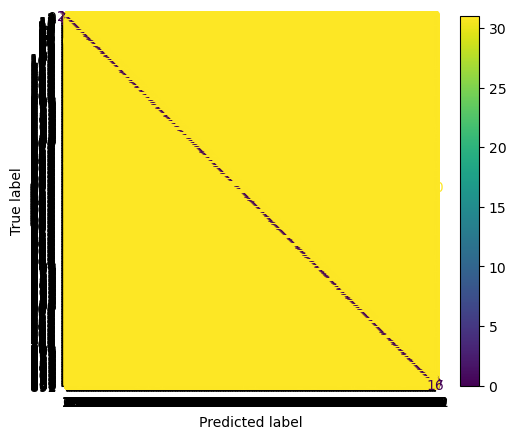

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ConfusionMatrixDisplay(
    confusion_matrix(
        train_df["topic"],
        train_df["context_topic_0"]
    )
).plot()